<a href="https://colab.research.google.com/github/AkshitAggarwal/Time_Series_Forecasting_Hopitalisations/blob/main/Covid_Hospitalizations_Minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

In [ ]:
dataset = pd.read_csv("Data_Minor_test.csv",parse_dates=True,dayfirst=True,index_col=0)
dataset.index.freq='D'
testset = pd.read_csv("UK-Final.csv",parse_dates=True,dayfirst=True,index_col=0)
testset.index.freq='D'

In [ ]:
dataset.head()

,Beds Occupied
Date,
2020-07-16,38532
2020-07-17,40057
2020-07-18,40372
2020-07-19,37895
2020-07-20,41136


In [ ]:
testset.head()

,Beds Occupied
Date,
2020-03-28,8278
2020-03-29,9525
2020-03-30,11093
2020-03-31,12597
2020-04-01,13637


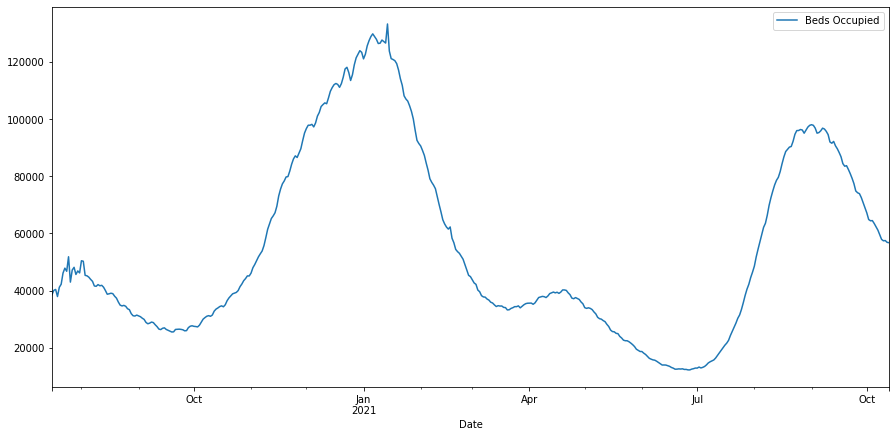

In [ ]:
dataset.plot(figsize=(15,7))

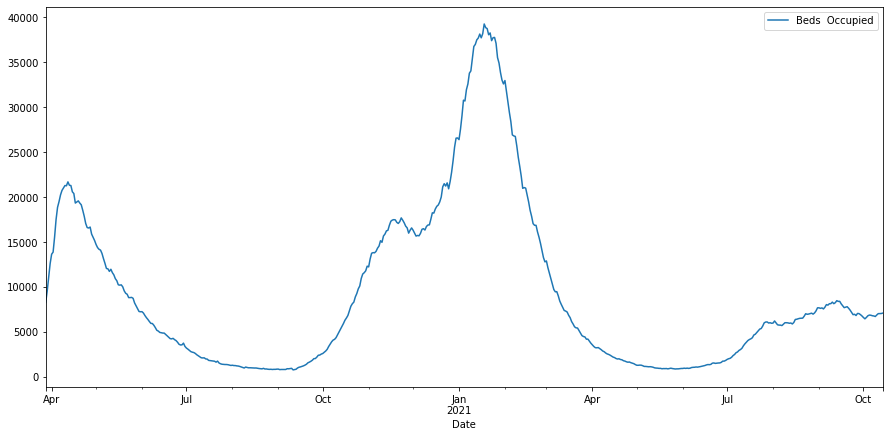

In [ ]:
testset.plot(figsize=(15,7))

In [ ]:
train = testset
test = testset

In [ ]:
train = testset[:int(len(testset)*0.8)]['Beds  Occupied'].values.reshape(-1, 1)
test = testset[int(len(testset)*0.8):]['Beds  Occupied'].values.reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

In [ ]:
scaler.fit(train) 
# scaler2.fit(test['Beds  Occupied'].values.reshape(-1, 1))
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
max(scaled_train)

array([1.])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 20
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=8)

In [ ]:
# X , y = generator[1]
# print(f'Given the Array: \n{X}')
# print(f'Predict this y: \n {y}')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
54/54 [==============================] - 4s 19ms/step - loss: 0.0389
Epoch 2/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0135
Epoch 3/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0076
Epoch 4/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0059
Epoch 5/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0203
Epoch 6/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0071
Epoch 7/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0043
Epoch 8/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0045
Epoch 9/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0032
Epoch 10/100
54/54 [==============================] - 1s 18ms/step - loss: 0.0024
Epoch 11/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 12/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0016
Epoch 13/100
54/54 [=====

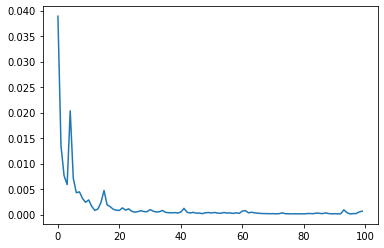

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-25:]

In [ ]:
#last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
#model.predict(last_train_batch)

In [ ]:
scaled_test[0]

array([0.01886498])

In [ ]:
test_predictions = []

first_eval_batch = scaled_test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in tqdm(range(len(test) - n_input)):
    current_pred = model.predict(scaled_test[i:i+n_input].reshape((1, n_input, n_features)))[0]
    test_predictions.append(current_pred) 
    # current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

100%|██████████| 94/94 [00:04<00:00, 20.95it/s]


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

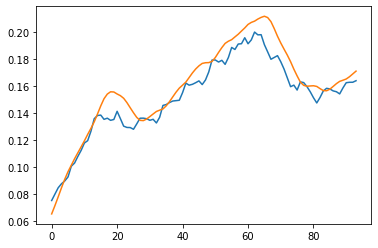

In [ ]:
plt.plot(scaled_test[n_input:])
plt.plot(test_predictions)